In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from spcqe.quantiles import SmoothPeriodicQuantiles

In [2]:
def process_excel_file(file_name, year):
    # Check if the year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Define the start and end of your time range
    start = pd.Timestamp(f'{year}-01-01 00:00:00')
    end = pd.Timestamp(f'{year}-12-31 23:00:00')
    
    # Create an hourly time index between start and end
    time_index = pd.date_range(start, end, freq='H')
    
    # Read the Excel file and select columns
    df = pd.read_excel(file_name, sheet_name='RI', usecols=['RT_Demand', 'Dry_Bulb', 'RT_LMP'])
    
    # Assign your new time index to your dataframe
    df.index = time_index
    
    return df

years = [2019, 2020, 2021, 2022]
paths = [Path() / 'fixtures' / f'{year}_smd_hourly.xlsx' for year in years]
df_list = [process_excel_file(path, year) for (path, year) in zip(paths, years)]

df = pd.concat(df_list)
df

,RT_Demand,RT_LMP,Dry_Bulb
2019-01-01 00:00:00,723.322,35.90,42
2019-01-01 01:00:00,688.771,38.81,44
2019-01-01 02:00:00,660.226,21.32,44
2019-01-01 03:00:00,642.773,18.52,46
2019-01-01 04:00:00,638.376,7.57,49
...,...,...,...
2022-12-31 19:00:00,876.594,26.33,49
2022-12-31 20:00:00,832.016,25.35,50
2022-12-31 21:00:00,793.269,31.66,49
2022-12-31 22:00:00,755.760,44.33,48


In [3]:
P1 = int(365*24)
P2 = int(7*24)
P3 = int(24)
K = 3
l = 0.1
spq = SmoothPeriodicQuantiles(K, [P1, P2, P3], percentiles=[80], weight=l, verbose=False)
spq

SmoothPeriodicQuantiles(num_harmonics=3, percentiles=[80],
                        periods=[8760, 168, 24], weight=0.1)

In [4]:
y1 = df['RT_Demand']
spq.fit(y1)
print(f"total time: {spq.fit_time:.2f} seconds")

total time: 8.66 seconds


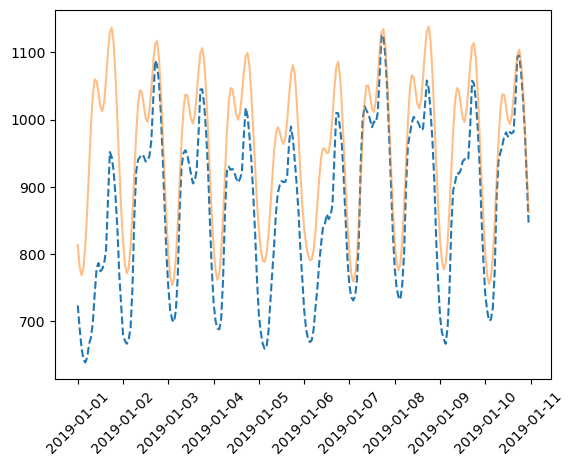

In [5]:
ix = 0
slc = np.s_[24 * ix:24 * (ix + 10)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
plt.plot(xs, spq.quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

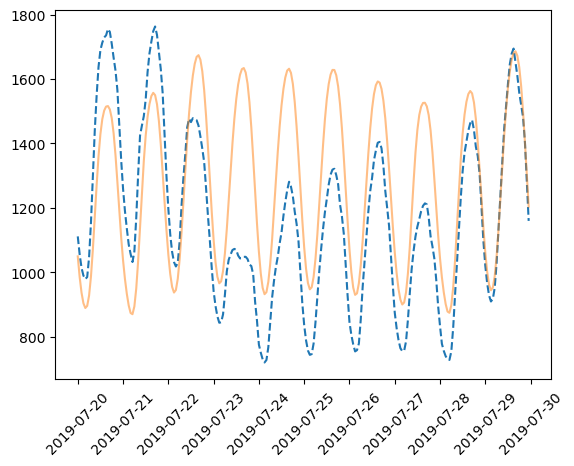

In [6]:
ix = 200
slc = np.s_[24 * ix:24 * (ix + 10)]
xs = df.index[slc]
plt.plot(xs, y1[slc], ls='--')
plt.plot(xs, spq.quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

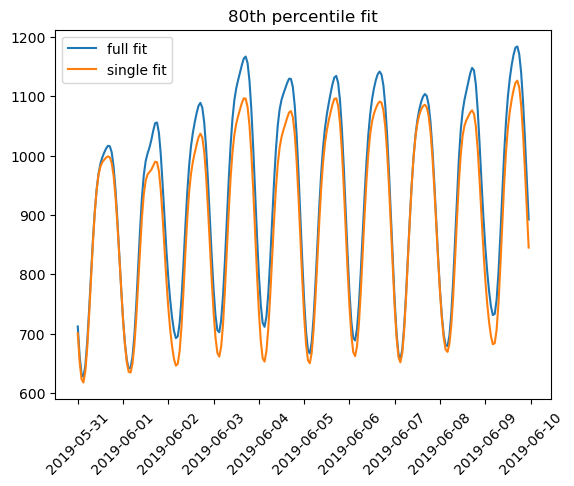

In [11]:
ix = 150
slc = np.s_[24 * ix:24 * (ix + 10)]
xs = df.index[slc]
saved_quantiles = np.loadtxt('quantiles_saved.txt')
plt.plot(xs, saved_quantiles[slc, 9], label='full fit')
plt.plot(xs, spq.quantiles[slc, :], label='single fit')
plt.legend()
plt.title(f"{spq.percentiles[0]}th percentile fit")
plt.xticks(rotation=45);